In [12]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import load_model, load_df, PLOTS_DIR_PATH

In [10]:
# Load results
results_df = load_df('statistical_results_hypochondriacus_caudatus_df.csv')
# Filter significant results
significant_results = results_df[(results_df['padj'] < 0.05) & (abs(results_df['log2FoldChange']) > 1)]

# Top 3 genes for each species
top_hypo = significant_results[significant_results['log2FoldChange'] > 0].nsmallest(3, 'padj')
top_cauda = significant_results[significant_results['log2FoldChange'] < 0].nsmallest(3, 'padj')

# Combine gene names
top_genes = list(top_hypo.index) + list(top_cauda.index)

dds = load_model(['species'])

Successfully loaded model: dds_species


/var/folders/c9/wqdv7km12lj1fc69vz1mfn_r0000gn/T/ipykernel_17350/1002320406.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(italic_labels, rotation=15, fontsize=25)
/var/folders/c9/wqdv7km12lj1fc69vz1mfn_r0000gn/T/ipykernel_17350/1002320406.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(italic_labels, rotation=15, fontsize=25)
/var/folders/c9/wqdv7km12lj1fc69vz1mfn_r0000gn/T/ipykernel_17350/1002320406.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(italic_labels, rotation=15, fontsize=25)
/var/folders/c9/wqdv7km12lj1fc69vz1mfn_r0000gn/T/ipykernel_17350/1002320406.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

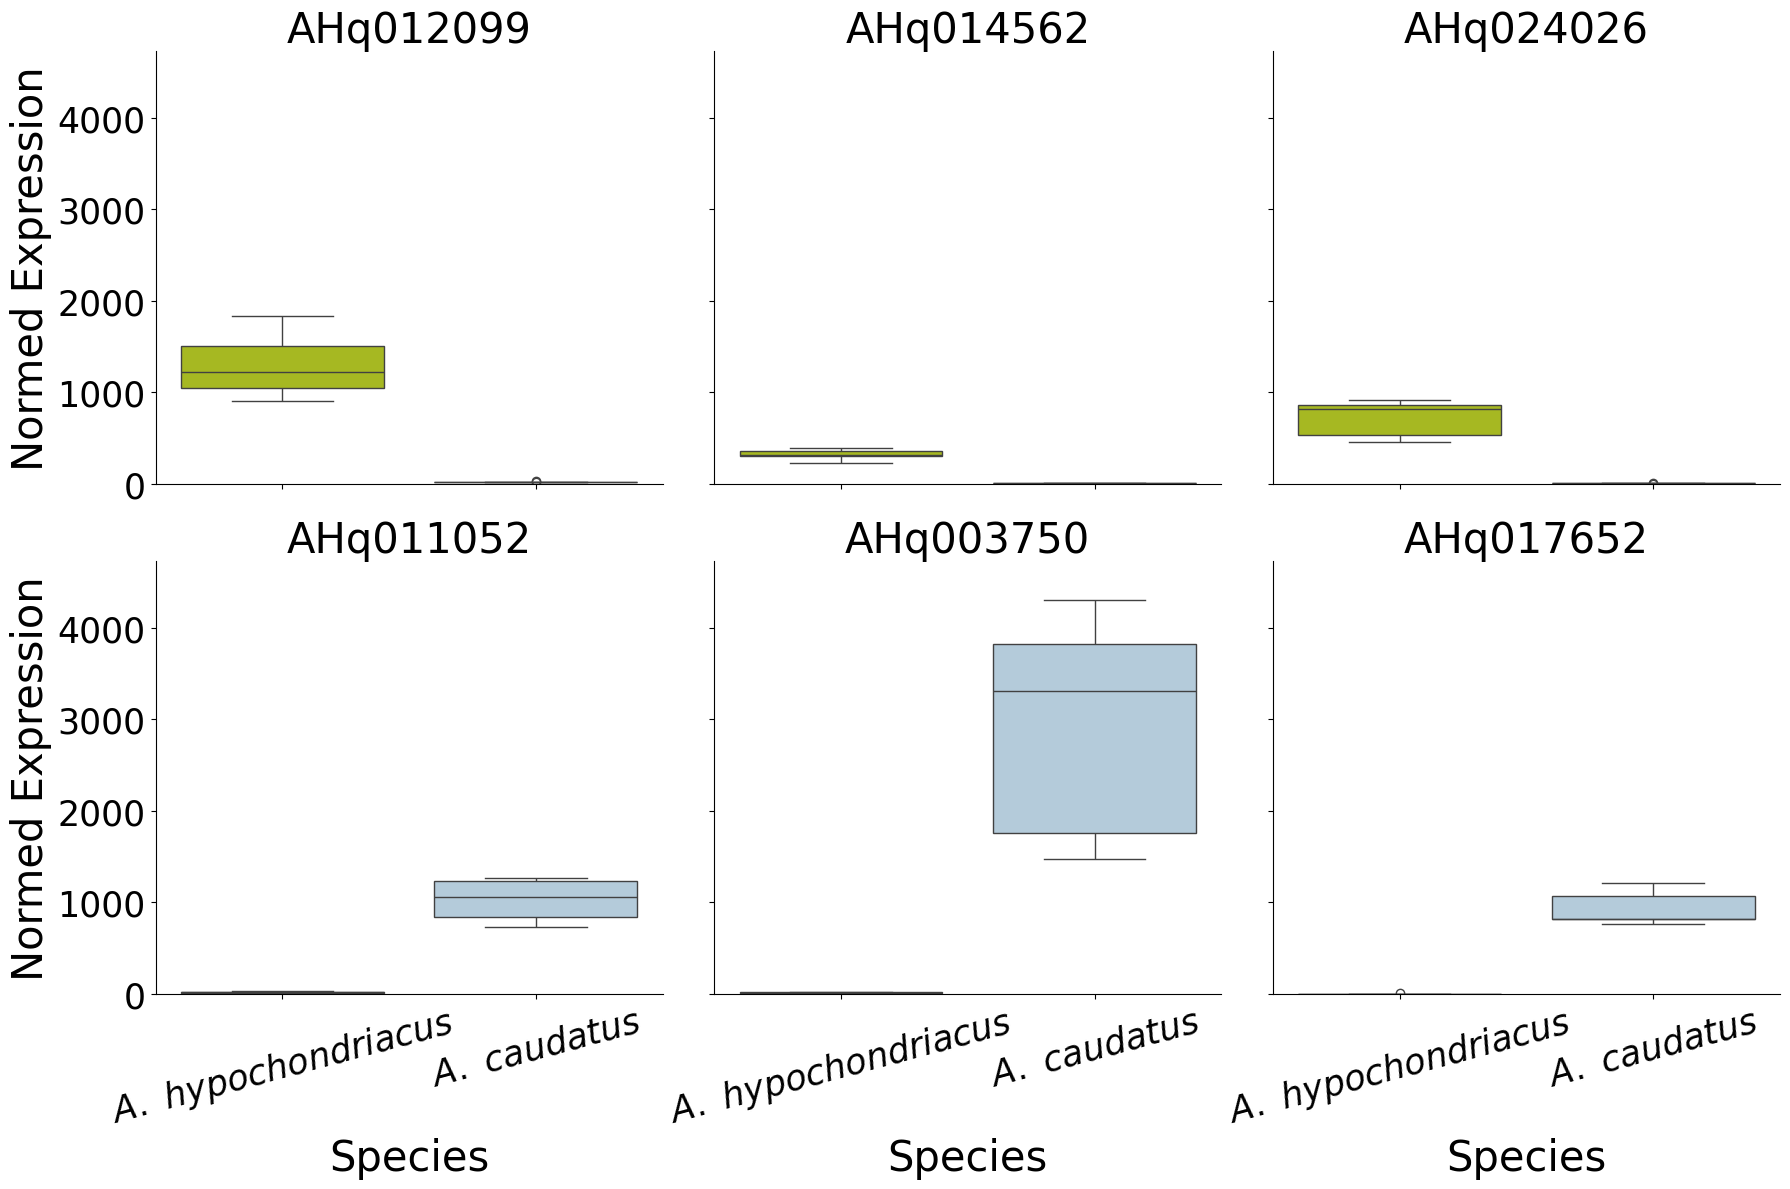

In [13]:
# Load results
results_df = load_df('statistical_results_hypochondriacus_caudatus_df.csv')

# 1. Filter statistical results
significant = results_df[(results_df['padj'] < 0.05) & (results_df['log2FoldChange'].abs() > 1)]
top_hypo = significant[significant['log2FoldChange'] > 0].nsmallest(3, 'padj')
top_cauda = significant[significant['log2FoldChange'] < 0].nsmallest(3, 'padj')
top_genes = list(top_hypo.index) + list(top_cauda.index)

# 2. Extract normalized counts
normed_counts = dds[:, top_genes].layers['normed_counts']
normed_counts_df = pd.DataFrame(normed_counts, index=dds.obs_names, columns=top_genes)

# 3. Merge with metadata
meta = dds.obs.copy()
meta['sample_id'] = meta.index
meta['species'] = meta['species'].replace({
    'hypochondriacus': 'A. hypochondriacus',
    'caudatus': 'A. caudatus'
})

combined = pd.concat([meta, normed_counts_df], axis=1)

# 4. Melt for plotting
melted = combined.melt(id_vars=['sample_id', 'species'], value_vars=top_genes,
                       var_name='gene', value_name='expression')

# 5. Custom color palette
custom_palette = {
    "A. hypochondriacus": "#b9d109",
    "A. caudatus": "#aecde0"
}

# 6. Plot with shared y-axis
g = sns.FacetGrid(melted, col="gene", col_wrap=3, sharey=True, height=6)
g.map_dataframe(
    sns.boxplot,
    x='species',
    y='expression',
    order=["A. hypochondriacus", "A. caudatus"],
    palette=custom_palette
)

g.set_axis_labels("Species", "Normed Expression", fontsize=30)
g.set_titles("{col_name}", size=30)

italic_labels = [r"$\it{A.\ hypochondriacus}$", r"$\it{A.\ caudatus}$"]
for ax in g.axes.flat:
    ax.set_xticklabels(italic_labels, rotation=15, fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.set_ylim(0, melted['expression'].max() * 1.1)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR_PATH, 'expression_level_boxplots.pdf'), bbox_inches="tight")
plt.show()